# Codenation  - final project
## Squad-4
### Finding leads using random forest


This code provides suggestions for market leads based on an company portfolio (input).
The leads are extracted from a larger data base (market.csv) and a probability is atributed to the most adherent companies from the input portfolio.

The approach used in this study is random forest regressor and is implemented by the following steps:

1) data cleaning and adjustments
* removes non-informative variables
* transforms boolean and object variables to numeric


---

> Import packages

In [1]:
import numpy as np
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_letters
import time
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

> Read files

In [3]:
market=pd.read_csv("estaticos_market.csv")
market_original=market
portfolio_01=pd.read_csv('estaticos_portfolio1.csv')
portfolio_02=pd.read_csv('estaticos_portfolio2.csv')
portfolio_03=pd.read_csv('estaticos_portfolio3.csv')

## Data treatment

> Remove variables:
   * non-informative variables (contains just one unique value )
   * 'Unnamed: 0' 

In [4]:
market=market.drop(['Unnamed: 0'],axis=1)
market_fill=market.count()
market=market[market_fill[market_fill>0].index]
market_unique=market.T.apply(lambda x: x.nunique(), axis=1)
list_one=market_unique.index[market_unique.values==1]
market=market[market_unique[market_unique>1].index]
market.shape

(462298, 169)

> Below, the list of non-informative variables removed

In [5]:
list(list_one)

['fl_epp',
 'qt_coligados_nula',
 'qt_coligados_atividade_alto',
 'qt_coligados_atividade_medio',
 'qt_coligados_atividade_baixo',
 'qt_coligados_atividade_mt_baixo',
 'qt_coligados_atividade_inativo']

> change variables values from boolean (True/False) or (SIM/NAO) to numeric (1/0)

In [6]:
bool_var=market.dtypes[market.dtypes=='bool'].index
for i in bool_var: 
    market.loc[market[i]==True,i] = 1
    market.loc[market[i]==False,i] = 0
list_new_bool=('fl_spa',
               'fl_antt',
               'fl_veiculo',
               'fl_optante_simples',
               'fl_optante_simei',
               'fl_simples_irregular',
               'fl_passivel_iss')
for i in list_new_bool: 
    market.loc[market[i]==True,i] = 1
    market.loc[market[i]==False,i] = 0
market.loc[market['fl_rm']=='SIM','fl_rm']=1
market.loc[market['fl_rm']=='NAO','fl_rm']=0

market['fl_spa']=pd.to_numeric(market['fl_spa'])
market['fl_antt']=pd.to_numeric(market['fl_antt'])
market['fl_veiculo']=pd.to_numeric(market['fl_veiculo'])
market['fl_optante_simples']=pd.to_numeric(market['fl_optante_simples'])
market['fl_optante_simei']=pd.to_numeric(market['fl_optante_simei'])
market['fl_simples_irregular']=pd.to_numeric(market['fl_simples_irregular'])
market['fl_passivel_iss']=pd.to_numeric(market['fl_passivel_iss'])

> ordinal order are atributed to object variables (listed below) that presents ordinal "string" values:
   * 'de_faixa_faturamento_estimado_grupo'
   * 'de_faixa_faturamento_estimado'
   * 'idade_emp_cat'
   * 'de_saude_rescencia'
   * 'de_nivel_atividade'
   * 'de_indicador_telefone'

In [7]:
market.loc[market['de_faixa_faturamento_estimado_grupo']=='ATE R$ 81.000,00',
           'de_faixa_faturamento_estimado_grupo']=0
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 81.000,01 A R$ 360.000,00',
           'de_faixa_faturamento_estimado_grupo']=1
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 360.000,01 A R$ 1.500.000,00',
           'de_faixa_faturamento_estimado_grupo']=2
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 1.500.000,01 A R$ 4.800.000,00',
           'de_faixa_faturamento_estimado_grupo']=3
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 4.800.000,01 A R$ 10.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=4
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 10.000.000,01 A R$ 30.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=5
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 30.000.000,01 A R$ 100.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=6
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 100.000.000,01 A R$ 300.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=7
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 300.000.000,01 A R$ 500.000.000,00',
           'de_faixa_faturamento_estimado_grupo']=8
market.loc[market['de_faixa_faturamento_estimado_grupo']=='DE R$ 500.000.000,01 A 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado_grupo']=9
market.loc[market['de_faixa_faturamento_estimado_grupo']=='ACIMA DE 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado_grupo']=10

market.loc[market['de_faixa_faturamento_estimado']=='ATE R$ 81.000,00',
           'de_faixa_faturamento_estimado']=0
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 81.000,01 A R$ 360.000,00',
           'de_faixa_faturamento_estimado']=1
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 360.000,01 A R$ 1.500.000,00',
           'de_faixa_faturamento_estimado']=2
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 1.500.000,01 A R$ 4.800.000,00',
           'de_faixa_faturamento_estimado']=3
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 4.800.000,01 A R$ 10.000.000,00',
           'de_faixa_faturamento_estimado']=4
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 10.000.000,01 A R$ 30.000.000,00',
           'de_faixa_faturamento_estimado']=5
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 30.000.000,01 A R$ 100.000.000,00',
           'de_faixa_faturamento_estimado']=6
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 100.000.000,01 A R$ 300.000.000,00',
           'de_faixa_faturamento_estimado']=7
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 300.000.000,01 A R$ 500.000.000,00',
           'de_faixa_faturamento_estimado']=8
market.loc[market['de_faixa_faturamento_estimado']=='DE R$ 500.000.000,01 A 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado']=9
market.loc[market['de_faixa_faturamento_estimado']=='ACIMA DE 1 BILHAO DE REAIS',
           'de_faixa_faturamento_estimado']=10
market.loc[market['de_faixa_faturamento_estimado']=='SEM INFORMACAO',
           'de_faixa_faturamento_estimado']=np.nan

market.loc[market['idade_emp_cat']=='<= 1',
           'idade_emp_cat']=0
market.loc[market['idade_emp_cat']=='1 a 5',
           'idade_emp_cat']=1
market.loc[market['idade_emp_cat']=='5 a 10',
           'idade_emp_cat']=2
market.loc[market['idade_emp_cat']=='10 a 15',
           'idade_emp_cat']=3
market.loc[market['idade_emp_cat']=='15 a 20',
           'idade_emp_cat']=4
market.loc[market['idade_emp_cat']=='> 20',
           'idade_emp_cat']=5

market.loc[market['de_saude_rescencia']=='ATE 3 MESES',
           'de_saude_rescencia']=0
market.loc[market['de_saude_rescencia']=='ATE 6 MESES',
           'de_saude_rescencia']=1
market.loc[market['de_saude_rescencia']=='ATE 1 ANO',
           'de_saude_rescencia']=2
market.loc[market['de_saude_rescencia']=='ACIMA DE 1 ANO',
           'de_saude_rescencia']=3
market.loc[market['de_saude_rescencia']=='SEM INFORMACAO',
           'de_saude_rescencia']=np.nan

market.loc[market['de_nivel_atividade']=='MUITO BAIXA',
           'de_nivel_atividade']=0
market.loc[market['de_nivel_atividade']=='BAIXA',
           'de_nivel_atividade']=1
market.loc[market['de_nivel_atividade']=='MEDIA',
           'de_nivel_atividade']=2
market.loc[market['de_nivel_atividade']=='ALTA',
           'de_nivel_atividade']=3

market.loc[market['de_indicador_telefone']=='BOA',
           'de_indicador_telefone']=1
market.loc[market['de_indicador_telefone']=='INDETERMINADA',
           'de_indicador_telefone']=np.nan

market['de_faixa_faturamento_estimado_grupo']=pd.to_numeric(market['de_faixa_faturamento_estimado_grupo'])
market['de_faixa_faturamento_estimado']=pd.to_numeric(market['de_faixa_faturamento_estimado'])
market['de_saude_rescencia']=pd.to_numeric(market['de_saude_rescencia'])
market['idade_emp_cat']=pd.to_numeric(market['idade_emp_cat'])
market['de_nivel_atividade']=pd.to_numeric(market['de_nivel_atividade'])
market['de_indicador_telefone']=pd.to_numeric(market['de_indicador_telefone'])

> Date variable ('dt_situacao') transfomed to ordinal

In [8]:
test=market['dt_situacao'].dropna()
test=test.astype('datetime64[ns]')
for i in test.index:
    test[i]=test[i].to_pydatetime().toordinal()
market['dt_situacao']=test
market['dt_situacao']=pd.to_numeric(market['dt_situacao'])

> Since there are some variables with many "nan", only the features with at least a given percentage of filled values are chosen.
The following plot presents the number of features that have at least a given percentage of filled values (not nan).

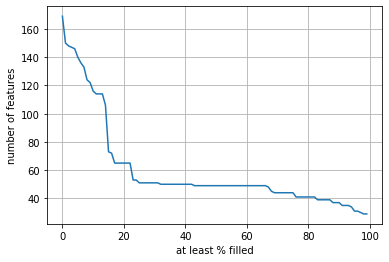

In [9]:
count_market=market.count()
count_market_max=max(count_market)
index = range(0,100)
columns = ['count_features']
n_features = pd.DataFrame(index=index, columns=columns)
for i in range(0,100):
    threshsold=round(i*count_market_max/100)
    n_features.values[i]=sum(count_market>threshsold)
fig, ax = plt.subplots()
ax.plot(n_features)
ax.set(xlabel='at least % filled', ylabel='number of features',
       title='')
ax.grid()

> The **threshold** value provides the minimum amount (%) of data required to inclue the feature in the dataset. 

In [10]:
threshold=0.8

In [11]:
count_market=market.count()
count_market_max=count_market['id']
threshsold_n=round(threshold*count_market_max)
market=market[count_market[count_market>threshsold_n].index]
market.shape

(462298, 41)

> Bar plot showing the features with 'nan' and respective number of 'nan's

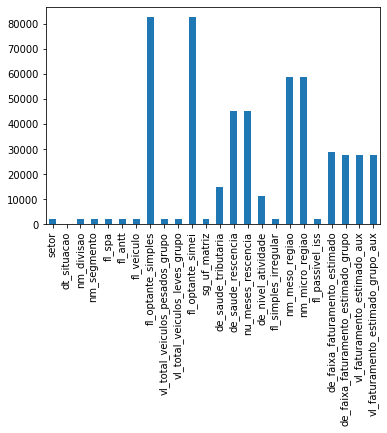

In [12]:
sum_nan=market.isnull().sum(axis = 0)
sum_nan=sum_nan[sum_nan>0]
sum_nan.plot.bar()

> Fill variables above with respective modes

In [13]:
for i in sum_nan.index:
    market[i] = market[i].fillna(market[i].mode()[0])

 > One hot encoding for the remaining 'object' variables

In [14]:
market=pd.concat([market,pd.get_dummies(market['de_natureza_juridica'])],axis=1).drop(['de_natureza_juridica'],axis=1)
market=pd.concat([market,pd.get_dummies(market['sg_uf'])],axis=1).drop(['sg_uf'],axis=1)
market=pd.concat([market,pd.get_dummies(market['natureza_juridica_macro'])],axis=1).drop(['natureza_juridica_macro'],axis=1)
market=pd.concat([market,pd.get_dummies(market['de_ramo'])],axis=1).drop(['de_ramo'],axis=1)
market=pd.concat([market,pd.get_dummies(market['setor'])],axis=1).drop(['setor'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_divisao'])],axis=1).drop(['nm_divisao'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_segmento'])],axis=1).drop(['nm_segmento'],axis=1)
market=pd.concat([market,pd.get_dummies(market['sg_uf_matriz'],prefix='matriz')],axis=1).drop(['sg_uf_matriz'],axis=1)
market=pd.concat([market,pd.get_dummies(market['de_saude_tributaria'])],axis=1).drop(['de_saude_tributaria'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_meso_regiao'])],axis=1).drop(['nm_meso_regiao'],axis=1)
market=pd.concat([market,pd.get_dummies(market['nm_micro_regiao'])],axis=1).drop(['nm_micro_regiao'],axis=1)
market.shape

(462298, 381)

___

##  Radom forest model

For a given input portfolio, first we identify indexes of the listed companies in the market database.
A vector y is created with label 0 or 1 to each index according to its respective status: not client or client, respectively.

### Choose portfolio (input)

In [135]:
input_portfolio=portfolio_01
#input_portfolio=portfolio_02
#input_portfolio=portfolio_03

In [136]:
y=np.zeros(len(market))
index_True=market[market['id'].isin(input_portfolio['id'].values)].index
y[index_True]=1
X=market.drop('id',axis=1)

Data is divided in 3 parts:
* train (60%)
* validation (20%)
* test (20%)

Cross-validation was used to optimize the performance of the model, varying the following parameters:

* n_estimators
* max_depth

Since we have a unbalanced dataset (many 0, few 1) instead of accuracy, the criteria for optimization was the the metric (Ftp,fp) proposed in:
http://cyber.sci-hub.tw/MTAuMTE0NS8xODgyNDcxLjE4ODI0Nzk=/10.1145%401882471.1882479.pdf

In [137]:
X_train_base, X_test, y_train_base, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model optmization

In [138]:
grid_n_estimators=range(50,150,50)
grid_max_depth=range(10,30,10)

In [139]:
max_k=2 # number of cross-validation
f1=pd.DataFrame(columns=['n_estimators','max_depth','Ftp,fp'])
count=0
start = time.process_time()
for est in grid_n_estimators:
    for dep in grid_max_depth:
        rf = RandomForestRegressor(n_estimators=est,max_depth=dep)
        tp=0
        fp=0
        fn=0
        for k in range(1,(max_k+1)):
            X_train, X_val, y_train, y_val = train_test_split(X_train_base, y_train_base, test_size=0.2, random_state=k)  
            rf.fit(X_train, y_train)
            predictions = rf.predict(X_val)
            predictions[predictions>0]=1
            predictions[predictions<=0]=0
            aux_matrix=confusion_matrix(y_val, predictions)
            tp=tp+aux_matrix[1][1]
            fp=fp+aux_matrix[0][1]
            fn=fn+aux_matrix[1][0]
        f1.loc[count,'n_estimators']=est
        f1.loc[count,'max_depth']=dep
        f1.loc[count,'Ftp,fp']=2*tp/(2*tp+fp+fn)
        count=count+1
run_time=round(time.process_time() - start)
run_time

1103

Optimal values 

In [140]:
opt_df=pd.DataFrame(index=['n_estimators','max_depth'],columns=['value'])
est_opt=int(f1.loc[f1['Ftp,fp']==f1['Ftp,fp'].max(),'n_estimators'].min())
dep_opt=int(f1.loc[f1['Ftp,fp']==f1['Ftp,fp'].max(),'max_depth'].min())
opt_df.loc['n_estimators','value']=est_opt
opt_df.loc['max_depth','value']=dep_opt
opt_df

,value
n_estimators,50
max_depth,10


Run analysis for test data using optimal parameters

In [141]:
rf_opt = RandomForestRegressor(n_estimators=est_opt,max_depth=dep_opt)
rf_opt.fit(X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Confusion matrix of the model applied to the test set

In [142]:
predictions_test = rf_opt.predict(X_test)
predictions_test[predictions_test>0]=1
predictions_test[predictions_test<=0]=0
aux_matrix_test=confusion_matrix(y_test, predictions_test)
aux_matrix_test

array([[56255, 36102],
       [    0,   103]])

Other performance metrics

In [143]:
performance= pd.DataFrame(index=['precision','recall','f1','accuracy','Ftp,fp'],columns =['value']) 
tp=aux_matrix_test[1][1]
fp=aux_matrix_test[0][1]
tn=aux_matrix_test[0][0]
fn=aux_matrix_test[1][0]
performance.loc['precision','value']=round(tp/(tp+fp),2)
performance.loc['recall','value']=round(tp/(tp+fn),2)
performance.loc['f1','value']=round(2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))),2)
performance.loc['accuracy','value']=round((tp+tn)/(tp+tn+fp+fn),2)
performance.loc['Ftp,fp','value']=round(2*tp/(2*tp+fp+fn),2)
performance

,value
precision,0
recall,1
f1,0.01
accuracy,0.61
"Ftp,fp",0.01


Final analysis using the obtained model to find the leads in the market data

In [144]:
X=market.drop('id',axis=1)
rf_opt.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [145]:
predictions_final = rf_opt.predict(X)
predictions_final_binary = predictions_final.copy()
predictions_final_binary[predictions_final_binary>0]=1
predictions_final_binary[predictions_final_binary<=0]=0
aux_matrix_test=confusion_matrix(y, predictions_final_binary)
aux_matrix_test

array([[268667, 193076],
       [     0,    555]])

The possible leads are the companies classified as client but not part of the input portfolio.
A final filter is applied, removing companies that does not share the following caracteristics with the input portfolio:
* 'de_ramo'
* 'setor'
* 'nm_segmento'
* 'nm_divisao'
* 'natureza_juridica_macro'
* 'de_natureza_juridica'
* 'nm_meso_regiao'
* 'nm_micro_regiao'

Also, only the leads with the following characteristics are included:

* 'fl_st_especial'= False
* 'fl_simples_irregular'= False
* 'de_saude_tributaria' = 'VERDE'
* 'nu_meses_rescencia' <= 24
* 'de_nivel_atividade' = 'ALTA'
* 'de_indicador_telefone' = 'BOA'

In [146]:
input_portfolio_02=market_original[market_original['id'].isin(input_portfolio['id'])]
leads_all=market_original[(predictions_final_binary==1) & (y==0)]
leads_all.shape

(193076, 182)

In [118]:
input_portfolio_02=market_original[market_original['id'].isin(input_portfolio['id'])]
leads_all=market_original[(predictions_final_binary==1) & (y==0)]
leads_all=leads_all[leads_all['de_ramo'].isin(list(input_portfolio_02['de_ramo'].unique()))]
leads_all=leads_all[leads_all['setor'].isin(list(input_portfolio_02['setor'].unique()))]
leads_all=leads_all[leads_all['nm_segmento'].isin(list(input_portfolio_02['nm_segmento'].unique()))]
leads_all=leads_all[leads_all['nm_divisao'].isin(list(input_portfolio_02['nm_divisao'].unique()))]
leads_all=leads_all[leads_all['natureza_juridica_macro'].isin(list(input_portfolio_02['natureza_juridica_macro'].unique()))]
leads_all=leads_all[leads_all['de_natureza_juridica'].isin(list(input_portfolio_02['de_natureza_juridica'].unique()))]
leads_all=leads_all[leads_all['nm_meso_regiao'].isin(list(input_portfolio_02['nm_meso_regiao'].unique()))]
leads_all=leads_all[leads_all['nm_micro_regiao'].isin(list(input_portfolio_02['nm_micro_regiao'].unique()))]

leads_all=leads_all[leads_all['fl_st_especial']==False]
leads_all=leads_all[leads_all['fl_simples_irregular']==False]
leads_all=leads_all[leads_all['de_saude_tributaria']=='VERDE']
#leads_all=leads_all[leads_all['de_saude_tributaria']=='VERDE']
leads_all=leads_all[leads_all['nu_meses_rescencia']<=24]
leads_all=leads_all[leads_all['de_nivel_atividade']<='ALTA']
leads_all=leads_all[leads_all['de_indicador_telefone']=='BOA']
leads_all.shape

(131, 182)

Ranking the remaining leads according to the random forest regressor output values

> Output file: 'leads.csv'

In [147]:
prob_out=np.around(predictions_final[leads_all.index],3)
output=pd.DataFrame(columns=['id','prob'])
output.loc[:,'id']=market.loc[leads_all.index,'id'].values
output.loc[:,'prob']=prob_out
output=output.sort_values(by=['prob'],ascending=False)
output.to_csv('leads.csv')

---